In [18]:
import pandas as pd
import numpy as np
from sklearn import model_selection, linear_model, metrics
import xgboost
import warnings
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pickle
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier, XGBRegressor

warnings.filterwarnings("ignore")


In [4]:
df_cian = pd.read_csv('clean_data.csv')
df_cian.head()

,Цена за квадрат,Этаж,Общая,Метро,Цена,Этажность здания,Широта дома,Долгота дома,Широта метро,Долгота метро,До центра,До метро,Азимут
0,752522.0,9,99.52,Парк Победы,74890993.0,10,55.731342,37.514950,55.735885,37.517492,7.108388,0.530374,9.433
1,279208.0,4,60.60,Лианозово,16920000.0,16,55.894126,37.521438,55.897353,37.553153,16.845703,2.016353,311.844
2,2117647.0,5,139.90,Смоленская,296258823.0,5,55.748779,37.589725,55.747261,37.581945,2.037621,0.516970,6.947
3,548263.0,3,129.50,Минская,71000000.0,14,55.724524,37.496757,55.724791,37.496755,8.450356,0.029683,10.497
4,445920.0,6,52.70,Беломорская,23500000.0,20,55.869825,37.457761,55.864057,37.463808,16.499986,0.745486,330.591


In [7]:
drop_columns = ['Цена', 'Цена за квадрат', 'Метро','Широта метро','Долгота метро']

In [9]:
X = df_cian.drop(columns=drop_columns, axis=1)
y = df_cian['Цена за квадрат']

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [12]:
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [13]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [14]:
metrics.mean_absolute_error(y_train, lr.predict(X_train))

158868.4461636531

In [15]:
metrics.mean_absolute_error(y_test, lr.predict(X_test))

179841.58438940984

In [16]:
scale = preprocessing.StandardScaler()
scale.fit(X_train)

StandardScaler()

In [19]:
with open('scale.pkl', 'wb') as file:
    pickle.dump(scale, file)

In [20]:
X_train_norm = scale.transform(X_train)
X_test_norm = scale.transform(X_test)

In [21]:
scale_target = preprocessing.StandardScaler()
scale_target.fit(y_train.values.reshape(-1, 1))

StandardScaler()

In [22]:
with open('scale_target.pkl', 'wb') as file:
    pickle.dump(scale_target, file)

In [23]:
y_train_norm = scale_target.transform(y_train.values.reshape(-1, 1))
y_test_norm = scale_target.transform(y_test.values.reshape(-1, 1))

In [24]:
lr1 = linear_model.LinearRegression()
lr1.fit(X_train_norm, y_train_norm)

LinearRegression()

In [25]:
metrics.mean_squared_error(y_test_norm, lr1.predict(X_test_norm))

0.8750510258241183

In [26]:
lr_r = linear_model.Ridge(alpha=10.0)
lr_r.fit(X_train_norm, y_train_norm)

Ridge(alpha=10.0)

In [27]:
metrics.mean_squared_error(y_train_norm, lr_r.predict(X_train_norm))

0.5092418613823816

In [28]:
metrics.mean_squared_error(y_test_norm, lr_r.predict(X_test_norm))

0.8756608410099462

In [29]:
params = {
    "n_estimators": 1000,
    "max_depth": 10,
    "min_samples_split": 2,
    "learning_rate": 0.01,
}
xgb = xgboost.XGBRegressor(**params, silent=True)
xgb.fit(X_train_norm, y_train_norm)

XGBRegressor(learning_rate=0.01, max_depth=10, min_samples_split=2,
             n_estimators=1000)

In [30]:
metrics.mean_squared_error(y_train_norm, xgb.predict(X_train_norm))

0.00020106718608173122

In [31]:
metrics.mean_squared_error(y_test_norm, xgb.predict(X_test_norm))

0.5759228518253148

In [32]:
xgb.feature_importances_

array([0.273724  , 0.26498154, 0.09625544, 0.09229315, 0.0748635 ,
       0.06392714, 0.08361701, 0.0503382 ], dtype=float32)

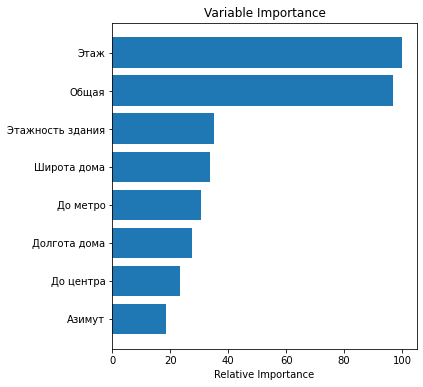

In [33]:
plt.figure(figsize=(12, 6))
# Plot feature importance
feature_importance = xgb.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

In [34]:
with open('xgb.pkl', 'wb') as file:
    pickle.dump(xgb, file)

In [35]:
np.random.seed(42)

mse_sample = []
for n_estimators in range(300, 1100, 100):
    for max_depth in range(2, 10, 1):
        for min_samples_split in range(2, 4, 1):
            xgb1 = xgboost.XGBRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
            )
            xgb1.fit(X_train_norm, y_train_norm)
            xgb1_predict = xgb1.predict(X_test_norm)
            mse_sample.append(
                [
                    n_estimators,
                    max_depth,
                    min_samples_split,
                    np.sum((y_test_norm - xgb1_predict) ** 2),
                ]
            )

In [36]:
sorted(mse_sample, key=lambda x: x[3])[0]

[300, 2, 2, 427862.1873120368]

In [37]:
params = {
    "n_estimators": 300,
    "max_depth": 2,
    "min_samples_split": 2,
    "learning_rate": 0.01,
}
xgb1 = xgboost.XGBRegressor(**params, silent=True)
xgb1.fit(X_train_norm, y_train_norm)

XGBRegressor(learning_rate=0.01, max_depth=2, min_samples_split=2,
             n_estimators=300)

In [38]:
metrics.mean_squared_error(y_train_norm, xgb1.predict(X_train_norm))

0.3460875607310865

In [39]:
metrics.mean_squared_error(y_test_norm, xgb1.predict(X_test_norm))

0.6876778246100026